In [1]:
import torch
from torch.autograd import Variable
dtype = torch.FloatTensor

In [2]:
import numpy as np
pi = np.pi
%matplotlib notebook
import matplotlib.pyplot as plt

## Simultaneous search for policy and verifying Lyapunov function

$$\dot{x} = f(x,u)$$

$$ u = \pi_\theta(x)) $$

$$ V(x) = p.s.d. \text{by construction, but parameterized by parameters } \psi $$

$$ \dot{V} = \frac{dV}{dx} \dot{x}$$
$$ = \big[ \frac{dV}{dx}\big]^T \big[f(x,\pi_{\theta}(x) \big] $$

### Loss function

$X$ = {$x_1, x_2, ..., x_N$} many samples

$$ L(\theta) = \sum_{i} l(x_i, \theta) $$

\begin{equation}
  \mathcal{l}(x_i,\theta) =
  \begin{cases}
    \dot{V}(x_i, \theta) & \text{if $\dot{V}(x_i, \theta) > 0$} \\
    0 & \text{otherwise}
  \end{cases}
\end{equation}



In [3]:
l = 1.0   # length in pixels
g = 1.0    # gravity in m/s**2
m = 1.0    # mass in kg
b = 1.0    # damping

x_i = Variable(torch.FloatTensor([1.0, 1.1]).type(dtype), requires_grad=True)
print x_i

P_size = 3
P = Variable(torch.FloatTensor([1, 1, 1]).type(dtype), requires_grad=True)
print P
### Step 1: compute V(x)
def compute_V(x):
    '''V(x) = x_1^2 + x_2^2'''
    monomials = Variable(torch.zeros(P_size))
    monomials[0] = x[1].pow(2)
    monomials[1] = torch.cos(x[0])
    monomials[2] = 1
    polynomial = torch.dot(P, monomials)
    return polynomial.pow(2)

def compute_V_energy_based(x):
    '''V(x) = (E - E_d)^2'''
    energy = 0.5*m*l**2*x[1]**2 + m*g*l*torch.cos(x[0])
    energy_desired = m*g*l
    difference_squared = (energy-energy_desired).pow(2)
    return difference_squared

print x_i.shape
print "V is", compute_V(x_i)
x_i_2 = Variable(torch.FloatTensor([1.1, 2.2]).type(dtype), requires_grad=True)
print "V is", compute_V(x_i_2)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]).type(dtype), requires_grad=True)

def compute_V_vectorized(x):
    monomials = Variable(torch.zeros(K_size, x.shape[1]))
    monomials[0] = x[1,:].pow(2)
    monomials[1] = torch.cos(x[0,:])
    monomials[2] = 1
    P_transpose = torch.t(P.unsqueeze(1))
    polynomial = P_transpose.mm(monomials)
    return polynomial.pow(2)

def compute_V_energy_based_vectorized(x):
    energy_vectorized = 0.5*m*l**2*x[1,:].pow(2) + m*g*l*torch.cos(x[0,:])
    energy_desired = m*g*l
    difference_squared = (energy_vectorized-energy_desired).pow(2)
    return difference_squared
    
print many_x_i
print compute_V_energy_based_vectorized(many_x_i)

Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Variable containing:
 1
 1
 1
[torch.FloatTensor of size 3]

torch.Size([2])
V is Variable containing:
 7.5642
[torch.FloatTensor of size 1]

V is Variable containing:
 39.6094
[torch.FloatTensor of size 1]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
 0.0211
 3.5104
 9.5102
[torch.FloatTensor of size 3]



In [4]:
### Step 2: compute dV/dx

### Step 3: initialize policy parameters
# K = Variable(torch.FloatTensor([1, 2]).type(dtype), requires_grad=True)
# print K

### Step 4: define dynamics function
def dynamics(x):
    xdot = Variable(torch.zeros(2).type(dtype))
    xdot[0] = x[1]
    xdot[1] = -torch.dot(K,x)
    return xdot

def pendulum_policy(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    return -torch.dot(K,x-x_desired)

def pendulum_energy_policy(x):
    energy = 0.5*m*l**2*x[1]**2 + m*g*l*torch.cos(x[0])
    energy_desired = m*g*l
    return -1*x[1]*(energy - energy_desired)

K_size = 3
#K = torch.randn(K_size)
#K = Variable(K, requires_grad=True)
K = Variable(torch.FloatTensor([0.5*m*l**2, m*g*l, -m*g*l]).type(dtype), requires_grad=True)
def pendulum_policy_search(x):
    monomials = Variable(torch.zeros(K_size))
    monomials[0] = x[1].pow(3)
    monomials[1] = x[1]*torch.cos(x[0])
    monomials[2] = x[1]
    u = -torch.dot(K, monomials)
    return u

def pendulum_dynamics(x):
    xdot = Variable(torch.zeros(2).type(dtype))
    xdot[0] = x[1]
    u = pendulum_policy_search(x)
    xdot[1] = (m * g * l * torch.sin(x[0:1])) + u
    return xdot
    
xdot = pendulum_dynamics(x_i)
print xdot
print pendulum_dynamics(x_i_2)
print "policy search is", pendulum_policy_search(x_i)
print "policy search is", pendulum_policy_search(x_i_2)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]).type(dtype), requires_grad=True)

def dynamics_vectorized(x):
    xdot = Variable(torch.zeros(2,x.shape[1]).type(dtype))
    xdot[0,:] = x[1,:]
    K_transpose = torch.t(K.unsqueeze(1))
    xdot[1,:] = -K_transpose.mm(x)
    return xdot

def pendulum_policy_vectorized(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_desired_vectorized = torch.t(x_desired.repeat(x.shape[1], 1))
    K_transpose = torch.t(K.unsqueeze(1))
    return K_transpose.mm(x - x_desired_vectorized)

def pendulum_energy_policy_vectorized(x):
    energy_vectorized = 0.5*m*l**2*x[1,:]**2 + m*g*l*torch.cos(x[0,:])
    energy_desired = m*g*l
    return -K[0]*x[1,:]*(energy_vectorized - energy_desired)

def pendulum_policy_search_vectorized(x):
    monomials = Variable(torch.zeros(K_size, x.shape[1]))
    monomials[0] = x[1,:].pow(3)
    monomials[1] = x[1,:]*torch.cos(x[0,:])
    monomials[2] = x[1,:]
    K_transpose = torch.t(K.unsqueeze(1))
    return -K_transpose.mm(monomials)

def pendulum_dynamics_vectorized(x):
    xdot = Variable(torch.zeros(2,x.shape[1]).type(dtype))
    xdot[0,:] = x[1,:]
    u = pendulum_policy_search_vectorized(x)
    xdot[1,:] = (m * g * l * torch.sin(x[0:1])) + u
    return xdot
      
print many_x_i
print pendulum_dynamics_vectorized(many_x_i)
print "policy search is", pendulum_policy_search_vectorized(many_x_i)

Variable containing:
 1.1000
 0.6816
[torch.FloatTensor of size 2]

Variable containing:
 2.2000
-3.2307
[torch.FloatTensor of size 2]

policy search is Variable containing:
-0.1598
[torch.FloatTensor of size 1]

policy search is Variable containing:
-4.1219
[torch.FloatTensor of size 1]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
 1.1000  2.2000  3.0000
 0.6816 -3.2307 -8.3423
[torch.FloatTensor of size 2x3]

policy search is Variable containing:
-0.1598 -4.1219 -9.2516
[torch.FloatTensor of size 1x3]



In [5]:
## COMPARE ENERGY POLICY

print "energy computes", pendulum_energy_policy(x_i)
print "search computes", pendulum_policy_search(x_i)

energy computes Variable containing:
-0.1598
[torch.FloatTensor of size 1]

search computes Variable containing:
-0.1598
[torch.FloatTensor of size 1]



In [6]:
def compute_Vdot(x):
    V = compute_V(x)
#     print x.shape
#     print V.shape
#     print V
    V.backward(torch.ones(1).type(dtype),retain_graph=True)
#     print "x.grad is", x.grad
    jacobian_x = Variable(x.grad.data)
#     print "jacobian_x is", jacobian_x
    f = pendulum_dynamics(x)
    Vdot = torch.dot(jacobian_x,f)
    return Vdot

print "x_i is", x_i
if x_i.grad is not None:
    print x_i.grad.zero_()
Vdot = compute_Vdot(x_i)
print "Vdot is", Vdot
Vdot.backward()

def compute_Vdot_vectorized(x):
    V = compute_V_vectorized(x)
#     print V
#     print x.shape
#     print "x.grad is", x.grad
#    V.backward(torch.ones(1,1).type(dtype),retain_graph=True)
#     print x
    V.backward(torch.ones(1,x.shape[1]).type(dtype),retain_graph=True)
    jacobian_x = Variable(x.grad.data)
#     print "jacobian_x is", jacobian_x
    f = pendulum_dynamics_vectorized(x)
    Vdot = (jacobian_x*f).sum(dim=0)
    return Vdot

print "many_x_i is", many_x_i

Vdot_vec = compute_Vdot_vectorized(many_x_i)
print "Vdot_vec is", Vdot_vec
#Vdot.backward(torch.ones(many_x_i.shape[1]).type(dtype))
cost = Vdot_vec.clamp(min=0).sum()
print cost
cost.backward()
many_x_i.grad.data.zero_()



x_i is Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Vdot is Variable containing:
 3.1573
[torch.FloatTensor of size 1]

many_x_i is Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Vdot_vec is Variable containing:
    3.1573
 -203.6074
-1011.6996
[torch.FloatTensor of size 3]

Variable containing:
 3.1573
[torch.FloatTensor of size 1]




 0  0  0
 0  0  0
[torch.FloatTensor of size 2x3]

## First let's verify, no synthesis
 
K = [1, 2] and P = [1, 1] should be stable

In [7]:
#K = Variable(torch.FloatTensor([1, 2]).type(dtype), requires_grad=True)
#P = Variable(torch.FloatTensor([1, 1]).type(dtype), requires_grad=True)
for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        print i
        print compute_V(x_i)
        print Vdot.data[0]
        break

false, counterexample found:  Variable containing:
 2.1148
-0.3949
[torch.FloatTensor of size 2]

0
Variable containing:
 0.4075
[torch.FloatTensor of size 1]

0.141874879599


## Now let's search for K, from an initialization not stable

In [8]:
P = Variable(torch.rand(3).type(dtype), requires_grad=True)
K = Variable(torch.randn(3).type(dtype), requires_grad=True)

print "Initial P", P
print "Initial K", K


for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

Initial P Variable containing:
 0.7212
 0.0761
 0.4727
[torch.FloatTensor of size 3]

Initial K Variable containing:
 0.2227
-0.1826
-0.5641
[torch.FloatTensor of size 3]

false, counterexample found:  Variable containing:
 0.3047
-1.3620
[torch.FloatTensor of size 2]



In [101]:
# Reset 
P = Variable(torch.rand(3).type(dtype), requires_grad=True)
K = Variable(torch.randn(3).type(dtype), requires_grad=True)

<IPython.core.display.Javascript object>


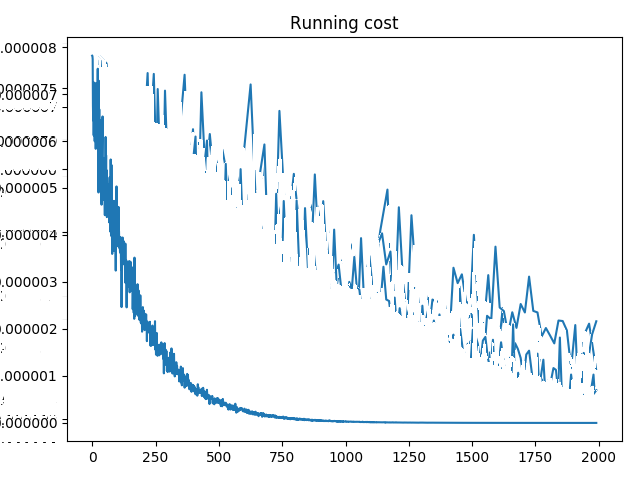

In [104]:
## optimization plotting tool

cost_current_iteration = 0
cost_history = []
cost_iteration_number_history = []

f, (cost_axis) = plt.subplots(1, 1)

cost_axis.plot(cost_iteration_number_history, cost_history)
cost_axis.set_title('Running cost')

plt.tight_layout()

In [105]:
## optimize

num_iterations = 2000
num_samples_per_iteration = 1000
step_rate = 1e-5
slack_var = .0

# K has already been initialized above, and initial policy visualized

import time
print "first P is", P
print "first K is", K

for cost_iteration in range(num_iterations):
    
    start = time.time()
    
    cost = 0
    
    samples = torch.randn(2,num_samples_per_iteration).type(dtype)
    many_x_i = Variable(samples, requires_grad=True)
    Vdot = compute_Vdot_vectorized(many_x_i)
    cost = Vdot.clamp(min=-slack_var).sum()
        
    ## Automatically differentiate
    cost.backward()

    # Update K via gradient descent
    K.data -= step_rate * K.grad.data
    P.data -= step_rate * P.grad.data
    
    # Project P into feasible
    #P.data = torch.abs(P.data)
    # Make P numerically stable by normalizing
    #P.data = P.data/(abs(P.data.pow(2).sum()))
      
    # Manually zero the gradients after running the backward pass
    K.grad.data.zero_()
    P.grad.data.zero_()
    
    print time.time() - start, "is time for one step of grad descent"
    print 
    print cost.data[0]
    
    # handle plotting
    cost_history.append(cost.data[0])
    cost_iteration_number_history.append(cost_iteration)
    
    if cost_iteration % 10 == 0:
        cost_axis.lines[0].set_xdata(cost_iteration_number_history)
        cost_axis.lines[0].set_ydata(cost_history)
        cost_axis.relim()
        cost_axis.autoscale_view()
        cost_axis.figure.canvas.draw()
        
    if cost.data[0] == 0:
        break
        
    print "P is", P
    print "K is", K
    
    if cost_iteration == num_iterations - 1:
        print "didn't converge"

first P is Variable containing:
1.00000e-04 *
 -0.1160
 -2.1694
  1.6669
[torch.FloatTensor of size 3]

first K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00244498252869 is time for one step of grad descent

7.81556718721e-06
P is Variable containing:
1.00000e-04 *
 -0.1174
 -2.1636
  1.6616
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00208687782288 is time for one step of grad descent

7.80987193139e-06
P is Variable containing:
1.00000e-04 *
 -0.1192
 -2.1581
  1.6569
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00187993049622 is time for one step of grad descent

7.74089858169e-06
P is Variable containing:
1.00000e-04 *
 -0.1191
 -2.1524
  1.6520
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00155997276306 is time for one step of grad descent

0.00353908538818 is time for one step of grad descent

4.64474851469e-06
P is Variable containing:
1.00000e-04 *
 -0.1089
 -1.9563
  1.5000
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00240206718445 is time for one step of grad descent

5.7921579355e-06
P is Variable containing:
1.00000e-04 *
 -0.1087
 -1.9503
  1.4955
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00233006477356 is time for one step of grad descent

5.60614671485e-06
P is Variable containing:
1.00000e-04 *
 -0.1096
 -1.9450
  1.4910
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00237393379211 is time for one step of grad descent

6.12467738392e-06
P is Variable containing:
1.00000e-04 *
 -0.1097
 -1.9396
  1.4870
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of si

P is Variable containing:
1.00000e-04 *
 -0.0958
 -1.6894
  1.2956
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00198602676392 is time for one step of grad descent

3.74915885004e-06
P is Variable containing:
1.00000e-04 *
 -0.0946
 -1.6848
  1.2919
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00226616859436 is time for one step of grad descent

3.81854397347e-06
P is Variable containing:
1.00000e-04 *
 -0.0927
 -1.6797
  1.2881
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00204491615295 is time for one step of grad descent

3.24187703882e-06
P is Variable containing:
1.00000e-04 *
 -0.0908
 -1.6752
  1.2852
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00197792053223 is time for one step of grad descent

4.02583418

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00177407264709 is time for one step of grad descent

3.56257032763e-06
P is Variable containing:
1.00000e-04 *
 -0.0853
 -1.5258
  1.1682
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00132393836975 is time for one step of grad descent

3.48962453245e-06
P is Variable containing:
1.00000e-04 *
 -0.0858
 -1.5217
  1.1645
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.0013689994812 is time for one step of grad descent

3.56147961611e-06
P is Variable containing:
1.00000e-04 *
 -0.0855
 -1.5177
  1.1615
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00123310089111 is time for one step of grad descent

2.98845702673e-06
P is Variable containing:
1.00000e-04 *
 -0.0851
 -1.5137
  1.1578
[torch.FloatTensor of si

P is Variable containing:
1.00000e-04 *
 -0.0809
 -1.3944
  1.0708
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00218486785889 is time for one step of grad descent

2.87747525363e-06
P is Variable containing:
1.00000e-04 *
 -0.0804
 -1.3905
  1.0681
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00195097923279 is time for one step of grad descent

2.6902494028e-06
P is Variable containing:
1.00000e-04 *
 -0.0807
 -1.3867
  1.0648
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00183391571045 is time for one step of grad descent

2.86779345515e-06
P is Variable containing:
1.00000e-04 *
 -0.0806
 -1.3828
  1.0614
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00169801712036 is time for one step of grad descent

2.345303528

0.00353097915649 is time for one step of grad descent

2.26374481826e-06
P is Variable containing:
1.00000e-04 *
 -0.0743
 -1.2711
  0.9756
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00158786773682 is time for one step of grad descent

2.11473798117e-06
P is Variable containing:
1.00000e-04 *
 -0.0745
 -1.2677
  0.9732
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00111985206604 is time for one step of grad descent

2.39100040744e-06
P is Variable containing:
1.00000e-04 *
 -0.0743
 -1.2640
  0.9701
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00122499465942 is time for one step of grad descent

2.31924923355e-06
P is Variable containing:
1.00000e-04 *
 -0.0736
 -1.2608
  0.9677
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of s

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00272703170776 is time for one step of grad descent

1.67341841006e-06
P is Variable containing:
1.00000e-04 *
 -0.0631
 -1.0839
  0.8311
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00152206420898 is time for one step of grad descent

1.45306933064e-06
P is Variable containing:
1.00000e-04 *
 -0.0620
 -1.0813
  0.8295
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00145602226257 is time for one step of grad descent

1.71590602349e-06
P is Variable containing:
1.00000e-04 *
 -0.0627
 -1.0783
  0.8268
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00200295448303 is time for one step of grad descent

1.79489677521e-06
P is Variable containing:
1.00000e-04 *
 -0.0625
 -1.0752
  0.8245
[torch.FloatTensor of s

P is Variable containing:
1.00000e-05 *
 -0.5649
 -9.7342
  7.4962
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00243806838989 is time for one step of grad descent

1.34334072754e-06
P is Variable containing:
1.00000e-05 *
 -0.5671
 -9.7061
  7.4761
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00222206115723 is time for one step of grad descent

1.33198591357e-06
P is Variable containing:
1.00000e-05 *
 -0.5599
 -9.6787
  7.4564
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00208592414856 is time for one step of grad descent

1.53235271227e-06
P is Variable containing:
1.00000e-05 *
 -0.5593
 -9.6516
  7.4348
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00211191177368 is time for one step of grad descent

1.35201185

P is Variable containing:
1.00000e-05 *
 -0.4727
 -8.2717
  6.3564
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00222301483154 is time for one step of grad descent

1.09631002942e-06
P is Variable containing:
1.00000e-05 *
 -0.4725
 -8.2514
  6.3369
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00206398963928 is time for one step of grad descent

8.53078688579e-07
P is Variable containing:
1.00000e-05 *
 -0.4724
 -8.2296
  6.3207
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00205898284912 is time for one step of grad descent

1.06206050532e-06
P is Variable containing:
1.00000e-05 *
 -0.4727
 -8.2059
  6.3040
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00291395187378 is time for one step of grad descent

8.00277632

P is Variable containing:
1.00000e-05 *
 -0.4100
 -7.2287
  5.5591
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00195288658142 is time for one step of grad descent

7.06587343302e-07
P is Variable containing:
1.00000e-05 *
 -0.4082
 -7.2101
  5.5435
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00193905830383 is time for one step of grad descent

7.79538765983e-07
P is Variable containing:
1.00000e-05 *
 -0.4030
 -7.1896
  5.5277
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00249099731445 is time for one step of grad descent

6.68375548685e-07
P is Variable containing:
1.00000e-05 *
 -0.3983
 -7.1713
  5.5153
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00221014022827 is time for one step of grad descent

7.66961875

P is Variable containing:
1.00000e-05 *
 -0.3549
 -6.1468
  4.7205
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00247716903687 is time for one step of grad descent

5.20202206644e-07
P is Variable containing:
1.00000e-05 *
 -0.3513
 -6.1296
  4.7080
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00233197212219 is time for one step of grad descent

5.13687950843e-07
P is Variable containing:
1.00000e-05 *
 -0.3498
 -6.1118
  4.6934
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00215411186218 is time for one step of grad descent

4.01810098083e-07
P is Variable containing:
1.00000e-05 *
 -0.3458
 -6.0944
  4.6818
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00216197967529 is time for one step of grad descent

5.61484228

P is Variable containing:
1.00000e-05 *
 -0.3002
 -5.2164
  4.0015
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00266098976135 is time for one step of grad descent

3.95270888021e-07
P is Variable containing:
1.00000e-05 *
 -0.2991
 -5.2017
  3.9895
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00231099128723 is time for one step of grad descent

3.78684632096e-07
P is Variable containing:
1.00000e-05 *
 -0.2949
 -5.1875
  3.9802
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00243616104126 is time for one step of grad descent

4.08124776641e-07
P is Variable containing:
1.00000e-05 *
 -0.2931
 -5.1736
  3.9686
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00272607803345 is time for one step of grad descent

4.09897722

0.0035228729248 is time for one step of grad descent

2.88208951815e-07
P is Variable containing:
1.00000e-05 *
 -0.2527
 -4.5065
  3.4606
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00167393684387 is time for one step of grad descent

2.69709687473e-07
P is Variable containing:
1.00000e-05 *
 -0.2533
 -4.4944
  3.4503
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00169610977173 is time for one step of grad descent

2.63776087195e-07
P is Variable containing:
1.00000e-05 *
 -0.2506
 -4.4827
  3.4436
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00163316726685 is time for one step of grad descent

2.42327985234e-07
P is Variable containing:
1.00000e-05 *
 -0.2465
 -4.4708
  3.4348
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of si

0.00382494926453 is time for one step of grad descent

2.14194827208e-07
P is Variable containing:
1.00000e-05 *
 -0.2229
 -3.8690
  2.9695
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00225114822388 is time for one step of grad descent

2.13724504761e-07
P is Variable containing:
1.00000e-05 *
 -0.2215
 -3.8591
  2.9613
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00230813026428 is time for one step of grad descent

2.47999878411e-07
P is Variable containing:
1.00000e-05 *
 -0.2222
 -3.8480
  2.9539
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00215911865234 is time for one step of grad descent

2.38649789708e-07
P is Variable containing:
1.00000e-05 *
 -0.2237
 -3.8376
  2.9463
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of s

P is Variable containing:
1.00000e-05 *
 -0.1939
 -3.3627
  2.5873
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00146198272705 is time for one step of grad descent

1.36743281587e-07
P is Variable containing:
1.00000e-05 *
 -0.1910
 -3.3532
  2.5810
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00140190124512 is time for one step of grad descent

1.51221357214e-07
P is Variable containing:
1.00000e-05 *
 -0.1891
 -3.3443
  2.5739
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00145506858826 is time for one step of grad descent

1.64526127833e-07
P is Variable containing:
1.00000e-05 *
 -0.1897
 -3.3351
  2.5660
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00131797790527 is time for one step of grad descent

1.59234858

P is Variable containing:
1.00000e-05 *
 -0.1784
 -3.0096
  2.3154
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00141191482544 is time for one step of grad descent

1.34295873977e-07
P is Variable containing:
1.00000e-05 *
 -0.1798
 -3.0014
  2.3091
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00134587287903 is time for one step of grad descent

1.60512144021e-07
P is Variable containing:
1.00000e-05 *
 -0.1781
 -2.9925
  2.3024
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00149512290955 is time for one step of grad descent

1.44281827374e-07
P is Variable containing:
1.00000e-05 *
 -0.1801
 -2.9845
  2.2957
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00142908096313 is time for one step of grad descent

1.14932511

P is Variable containing:
1.00000e-05 *
 -0.1599
 -2.6951
  2.0806
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00132298469543 is time for one step of grad descent

1.07760449453e-07
P is Variable containing:
1.00000e-05 *
 -0.1597
 -2.6878
  2.0753
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00147104263306 is time for one step of grad descent

9.79647936106e-08
P is Variable containing:
1.00000e-05 *
 -0.1583
 -2.6806
  2.0700
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00137209892273 is time for one step of grad descent

1.07020319717e-07
P is Variable containing:
1.00000e-05 *
 -0.1555
 -2.6732
  2.0652
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00135803222656 is time for one step of grad descent

1.24559079

P is Variable containing:
1.00000e-05 *
 -0.1315
 -2.2478
  1.7337
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00277805328369 is time for one step of grad descent

7.8961349459e-08
P is Variable containing:
1.00000e-05 *
 -0.1296
 -2.2418
  1.7301
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00264000892639 is time for one step of grad descent

8.25416464068e-08
P is Variable containing:
1.00000e-05 *
 -0.1295
 -2.2360
  1.7248
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00263285636902 is time for one step of grad descent

6.82192435875e-08
P is Variable containing:
1.00000e-05 *
 -0.1303
 -2.2304
  1.7200
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00243902206421 is time for one step of grad descent

7.281747116

P is Variable containing:
1.00000e-05 *
 -0.1040
 -1.9009
  1.4621
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00258588790894 is time for one step of grad descent

5.43540714659e-08
P is Variable containing:
1.00000e-05 *
 -0.1048
 -1.8961
  1.4579
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.0018618106842 is time for one step of grad descent

6.09207049251e-08
P is Variable containing:
1.00000e-05 *
 -0.1054
 -1.8912
  1.4534
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00201606750488 is time for one step of grad descent

5.26438554971e-08
P is Variable containing:
1.00000e-05 *
 -0.1050
 -1.8865
  1.4485
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00197291374207 is time for one step of grad descent

5.775995504

0.00394916534424 is time for one step of grad descent

4.2797786648e-08
P is Variable containing:
1.00000e-05 *
 -0.0923
 -1.7084
  1.3095
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00214219093323 is time for one step of grad descent

4.19384029726e-08
P is Variable containing:
1.00000e-05 *
 -0.0920
 -1.7043
  1.3064
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00206112861633 is time for one step of grad descent

3.63799550485e-08
P is Variable containing:
1.00000e-05 *
 -0.0914
 -1.6995
  1.3036
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00211501121521 is time for one step of grad descent

4.6947924659e-08
P is Variable containing:
1.00000e-05 *
 -0.0921
 -1.6951
  1.3000
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of siz

0.00460600852966 is time for one step of grad descent

2.98911082552e-08
P is Variable containing:
1.00000e-05 *
 -0.0784
 -1.4191
  1.0869
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00193691253662 is time for one step of grad descent

3.11419583454e-08
P is Variable containing:
1.00000e-05 *
 -0.0798
 -1.4152
  1.0835
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00173401832581 is time for one step of grad descent

2.92189543671e-08
P is Variable containing:
1.00000e-05 *
 -0.0790
 -1.4109
  1.0800
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00191903114319 is time for one step of grad descent

2.45445388458e-08
P is Variable containing:
1.00000e-05 *
 -0.0776
 -1.4072
  1.0782
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of s

0.00440001487732 is time for one step of grad descent

1.67584701671e-08
P is Variable containing:
1.00000e-05 *
 -0.0704
 -1.1628
  0.8920
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00220584869385 is time for one step of grad descent

1.97797653811e-08
P is Variable containing:
1.00000e-05 *
 -0.0698
 -1.1595
  0.8898
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00195217132568 is time for one step of grad descent

1.88347133445e-08
P is Variable containing:
1.00000e-05 *
 -0.0686
 -1.1564
  0.8876
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00237703323364 is time for one step of grad descent

1.80821988494e-08
P is Variable containing:
1.00000e-05 *
 -0.0681
 -1.1535
  0.8853
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of s

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00358295440674 is time for one step of grad descent

1.37751188234e-08
P is Variable containing:
1.00000e-06 *
 -0.5400
 -9.6571
  7.4105
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00270581245422 is time for one step of grad descent

1.40919089731e-08
P is Variable containing:
1.00000e-06 *
 -0.5457
 -9.6309
  7.3872
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00263810157776 is time for one step of grad descent

1.56316648514e-08
P is Variable containing:
1.00000e-06 *
 -0.5461
 -9.6055
  7.3642
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00269508361816 is time for one step of grad descent

1.27652537429e-08
P is Variable containing:
1.00000e-06 *
 -0.5423
 -9.5795
  7.3430
[torch.FloatTensor of s

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00236988067627 is time for one step of grad descent

1.21580878698e-08
P is Variable containing:
1.00000e-06 *
 -0.4193
 -8.1728
  6.2662
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00220489501953 is time for one step of grad descent

1.00327914865e-08
P is Variable containing:
1.00000e-06 *
 -0.4190
 -8.1501
  6.2496
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00206804275513 is time for one step of grad descent

1.01538306652e-08
P is Variable containing:
1.00000e-06 *
 -0.4247
 -8.1273
  6.2294
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00213384628296 is time for one step of grad descent

8.67539995397e-09
P is Variable containing:
1.00000e-06 *
 -0.4260
 -8.1069
  6.2144
[torch.FloatTensor of s

P is Variable containing:
1.00000e-06 *
 -0.3863
 -7.1350
  5.4693
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00252103805542 is time for one step of grad descent

7.51870476989e-09
P is Variable containing:
1.00000e-06 *
 -0.3854
 -7.1146
  5.4527
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00226712226868 is time for one step of grad descent

8.20172907368e-09
P is Variable containing:
1.00000e-06 *
 -0.3915
 -7.0947
  5.4353
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00223398208618 is time for one step of grad descent

7.94949173155e-09
P is Variable containing:
1.00000e-06 *
 -0.3988
 -7.0750
  5.4181
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00229716300964 is time for one step of grad descent

8.16301692

P is Variable containing:
1.00000e-06 *
 -0.3353
 -6.0462
  4.6473
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00215411186218 is time for one step of grad descent

5.25159737919e-09
P is Variable containing:
1.00000e-06 *
 -0.3317
 -6.0300
  4.6354
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00202393531799 is time for one step of grad descent

5.5999160864e-09
P is Variable containing:
1.00000e-06 *
 -0.3295
 -6.0131
  4.6225
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00235104560852 is time for one step of grad descent

4.98249042025e-09
P is Variable containing:
1.00000e-06 *
 -0.3321
 -5.9965
  4.6092
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00264501571655 is time for one step of grad descent

5.958908921

P is Variable containing:
1.00000e-06 *
 -0.3019
 -5.2705
  4.0590
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00334692001343 is time for one step of grad descent

4.29687041503e-09
P is Variable containing:
1.00000e-06 *
 -0.3040
 -5.2560
  4.0463
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00256109237671 is time for one step of grad descent

4.31367386255e-09
P is Variable containing:
1.00000e-06 *
 -0.3043
 -5.2409
  4.0334
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.0024299621582 is time for one step of grad descent

4.4039456526e-09
P is Variable containing:
1.00000e-06 *
 -0.3035
 -5.2256
  4.0209
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.0020968914032 is time for one step of grad descent

4.21418899776

P is Variable containing:
1.00000e-06 *
 -0.2480
 -4.6008
  3.5374
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00257802009583 is time for one step of grad descent

3.81751119605e-09
P is Variable containing:
1.00000e-06 *
 -0.2498
 -4.5887
  3.5246
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00281596183777 is time for one step of grad descent

2.88514345748e-09
P is Variable containing:
1.00000e-06 *
 -0.2470
 -4.5765
  3.5160
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00254082679749 is time for one step of grad descent

3.00831115574e-09
P is Variable containing:
1.00000e-06 *
 -0.2472
 -4.5641
  3.5062
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00263500213623 is time for one step of grad descent

3.35179639

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00235390663147 is time for one step of grad descent

2.47042653001e-09
P is Variable containing:
1.00000e-06 *
 -0.2310
 -3.9977
  3.0661
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00133895874023 is time for one step of grad descent

2.32181252002e-09
P is Variable containing:
1.00000e-06 *
 -0.2314
 -3.9863
  3.0576
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00215101242065 is time for one step of grad descent

2.07152828224e-09
P is Variable containing:
1.00000e-06 *
 -0.2306
 -3.9762
  3.0508
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00203800201416 is time for one step of grad descent

2.2060164806e-09
P is Variable containing:
1.00000e-06 *
 -0.2306
 -3.9656
  3.0418
[torch.FloatTensor of si

P is Variable containing:
1.00000e-06 *
 -0.1851
 -3.4116
  2.6177
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00280380249023 is time for one step of grad descent

1.5759802352e-09
P is Variable containing:
1.00000e-06 *
 -0.1853
 -3.4025
  2.6111
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00266218185425 is time for one step of grad descent

1.86902271437e-09
P is Variable containing:
1.00000e-06 *
 -0.1865
 -3.3930
  2.6039
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00273609161377 is time for one step of grad descent

1.51304446749e-09
P is Variable containing:
1.00000e-06 *
 -0.1878
 -3.3833
  2.5961
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.0027871131897 is time for one step of grad descent

1.5922282381

0.00407695770264 is time for one step of grad descent

1.2534790983e-09
P is Variable containing:
1.00000e-06 *
 -0.1607
 -2.9329
  2.2482
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.0021288394928 is time for one step of grad descent

1.38525835247e-09
P is Variable containing:
1.00000e-06 *
 -0.1612
 -2.9251
  2.2418
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00190806388855 is time for one step of grad descent

1.36425815089e-09
P is Variable containing:
1.00000e-06 *
 -0.1608
 -2.9171
  2.2357
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.0020158290863 is time for one step of grad descent

1.07184883191e-09
P is Variable containing:
1.00000e-06 *
 -0.1571
 -2.9093
  2.2318
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size

P is Variable containing:
1.00000e-06 *
 -0.1471
 -2.6681
  2.0449
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00174307823181 is time for one step of grad descent

9.40195032939e-10
P is Variable containing:
1.00000e-06 *
 -0.1457
 -2.6599
  2.0399
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00152277946472 is time for one step of grad descent

8.73763172926e-10
P is Variable containing:
1.00000e-06 *
 -0.1454
 -2.6533
  2.0349
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00149297714233 is time for one step of grad descent

1.0044880483e-09
P is Variable containing:
1.00000e-06 *
 -0.1449
 -2.6468
  2.0294
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00149202346802 is time for one step of grad descent

1.018607420

0.00410103797913 is time for one step of grad descent

7.86784470908e-10
P is Variable containing:
1.00000e-06 *
 -0.1214
 -2.2966
  1.7624
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00191712379456 is time for one step of grad descent

7.73186181746e-10
P is Variable containing:
1.00000e-06 *
 -0.1211
 -2.2906
  1.7559
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00218296051025 is time for one step of grad descent

8.13968947799e-10
P is Variable containing:
1.00000e-06 *
 -0.1206
 -2.2840
  1.7513
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00213885307312 is time for one step of grad descent

8.57325821446e-10
P is Variable containing:
1.00000e-06 *
 -0.1211
 -2.2780
  1.7468
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of s

P is Variable containing:
1.00000e-06 *
 -0.1107
 -2.0896
  1.6026
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.0023341178894 is time for one step of grad descent

6.2100785625e-10
P is Variable containing:
1.00000e-06 *
 -0.1086
 -2.0847
  1.5984
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00228691101074 is time for one step of grad descent

7.11541936482e-10
P is Variable containing:
1.00000e-06 *
 -0.1086
 -2.0786
  1.5928
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00182390213013 is time for one step of grad descent

6.84266865392e-10
P is Variable containing:
1.00000e-06 *
 -0.1086
 -2.0727
  1.5883
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00206184387207 is time for one step of grad descent

6.5175342900

P is Variable containing:
1.00000e-06 *
 -0.1049
 -1.9047
  1.4576
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00357604026794 is time for one step of grad descent

5.6550447658e-10
P is Variable containing:
1.00000e-06 *
 -0.1046
 -1.8994
  1.4533
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00269508361816 is time for one step of grad descent

5.48006584555e-10
P is Variable containing:
1.00000e-06 *
 -0.1028
 -1.8940
  1.4497
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00253391265869 is time for one step of grad descent

4.94982166366e-10
P is Variable containing:
1.00000e-06 *
 -0.1049
 -1.8885
  1.4451
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00267696380615 is time for one step of grad descent

5.096016386

P is Variable containing:
1.00000e-06 *
 -0.0944
 -1.6361
  1.2573
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00302696228027 is time for one step of grad descent

3.59774599001e-10
P is Variable containing:
1.00000e-06 *
 -0.0925
 -1.6317
  1.2549
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00238704681396 is time for one step of grad descent

3.88642146243e-10
P is Variable containing:
1.00000e-06 *
 -0.0915
 -1.6275
  1.2522
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00259113311768 is time for one step of grad descent

3.04993086342e-10
P is Variable containing:
1.00000e-06 *
 -0.0911
 -1.6233
  1.2491
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00248503684998 is time for one step of grad descent

3.33327337

P is Variable containing:
1.00000e-06 *
 -0.0768
 -1.3871
  1.0645
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00181293487549 is time for one step of grad descent

2.41738518092e-10
P is Variable containing:
1.00000e-06 *
 -0.0751
 -1.3837
  1.0622
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00191402435303 is time for one step of grad descent

2.69596234226e-10
P is Variable containing:
1.00000e-06 *
 -0.0750
 -1.3800
  1.0593
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00233101844788 is time for one step of grad descent

2.98387148323e-10
P is Variable containing:
1.00000e-06 *
 -0.0761
 -1.3760
  1.0565
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00216007232666 is time for one step of grad descent

2.83275319

0.00423812866211 is time for one step of grad descent

2.22179080689e-10
P is Variable containing:
1.00000e-06 *
 -0.0732
 -1.2483
  0.9567
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00203490257263 is time for one step of grad descent

2.35211877753e-10
P is Variable containing:
1.00000e-06 *
 -0.0731
 -1.2449
  0.9541
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00221991539001 is time for one step of grad descent

2.44966769092e-10
P is Variable containing:
1.00000e-06 *
 -0.0732
 -1.2414
  0.9510
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00223302841187 is time for one step of grad descent

2.14574774615e-10
P is Variable containing:
1.00000e-06 *
 -0.0740
 -1.2380
  0.9484
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of s

P is Variable containing:
1.00000e-06 *
 -0.0570
 -1.0552
  0.8092
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00218486785889 is time for one step of grad descent

1.59607493888e-10
P is Variable containing:
1.00000e-06 *
 -0.0583
 -1.0526
  0.8061
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00203585624695 is time for one step of grad descent

1.60774921154e-10
P is Variable containing:
1.00000e-06 *
 -0.0586
 -1.0495
  0.8037
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00225114822388 is time for one step of grad descent

1.99121275024e-10
P is Variable containing:
1.00000e-06 *
 -0.0599
 -1.0466
  0.8005
[torch.FloatTensor of size 3]

K is Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

0.00223708152771 is time for one step of grad descent

1.40861072

In [106]:
print K
print P

Variable containing:
 0.3207
 0.3102
-0.2648
[torch.FloatTensor of size 3]

Variable containing:
1.00000e-07 *
 -0.5415
 -9.2405
  7.0834
[torch.FloatTensor of size 3]



In [107]:
# THIS IS THE ANSWER
#K = Variable(torch.FloatTensor([0.5*m*l**2, m*g*l, -m*g*l]).type(dtype), requires_grad=True)
for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 1e-2:
        print "false, counterexample found: ", x_i
        print i
        print Vdot.data[0]
        break

In [21]:
# Note: first time I ended up with these values:

# print K
# print P
# Variable containing:
#   0.2410
#  16.2734
# [torch.FloatTensor of size 2]

# Variable containing:
#  0.3484
#  0.8831
# [torch.FloatTensor of size 2]

#Which gave only:

# # condition (a):  p_1 - p_2*k_1
# print P[0] - P[1]*K[0]

# # condition (b): k_2 > 0
# print K[1]

# Variable containing:
#  0.1356
# [torch.FloatTensor of size 1]

# Variable containing:
#  16.2734
# [torch.FloatTensor of size 1]

# But this was Vdot negative semidefinite over all samples, since k_2 was so large it could outweigh the first term